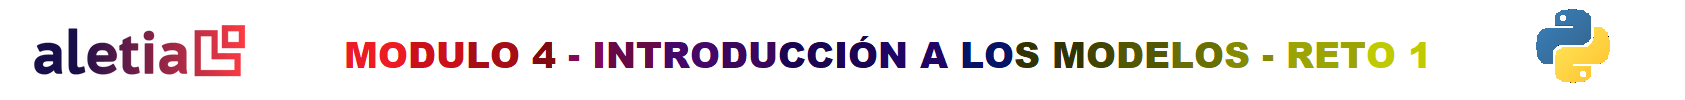

##**Repaso Regresión Lineal**

Recordemos que el modelo de regresión lineal asume que es posible estimar una variable $y$ a partir de la combinación lineal de varias variables $x_1, x_2, x_3, \cdots$ con sus coeficientes $\theta_1, \theta_2, \theta_3, \cdots$ y agregando un valor de escala $\theta_0$. A esta estimación le llamaremos $\hat{y}$

En términos matemáticos:

$y \approx \hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots$

##**Planteamiento del problema y descripción de los datos**

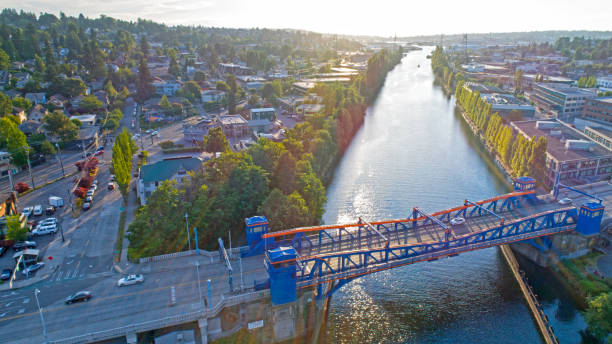
[Puente Fermont en Seattle](https://en.wikipedia.org/wiki/Fremont_Bridge_(Seattle)) 

- **RETO**
  *   **Predecir el número de viajes en bicicleta a través del puente Fermont en Seattle**

- **DATOS DISPONIBLES**
  *   Temperatura min y max
  *   Cantidad de agua por mm2
  *   Ubicación

- **ORIGEN DE LOS DATOS**
  *   [National Centers for environmental information](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (NOAA) Station ID de Seattle: `USW00024233`
  *   [Datos del gobierno de Seattle](https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD)
  *   Es interesante ver el origen de los datos pero si te da flojera puedes descargar las tablas directamente de: 
  [DATOS MODULO_4 RETO_1](https://mega.nz/#P!AgDbHSfcBEu78xaiYoUo7KL3iRtqEX1YmnEmY9h-n1v3dvZ6P1zDZT8xt-oIGj2GpU6C2ZkYSmvvnkAA-dpR9Xi7keUtTDQSMJEcjKvqlW3JicM-dEHo6w) con la contraseña: *datosreto4*
  

- **PLAN DE INGENIERÍA DE DATOS**
  *   En esta ocasión los datos que usaremos fueron previamente revisados, validados y limpios sin embargo los datos son muy simples y dificilmente podrían ayudar a tener una buena predicción por si mismos. Pero el trabajo de ingeniería de datos no solo consiste en limpiar y validar los datos sino en encontrar una **INGENIOSA** manera de transformarlos para que nos sean mas útiles, de ahí el nombre de *ingeniería*.
  *   Esta habilidad es crucial para determinar el seniority de un analista de datos y desafortunadamente no hay una metodología rígida que nos enseñe como hacerlo ya que este tipo de trabajo involucra mucha creatividad, pensamiento abstracto y holístico sobre un problema y es por eso que consideramos fundamental mostrar un ejemplo.
  *   La solución en realidad es muy simple. La parte dificil es hacer que esa solución emerja del planteamiento del problema y los datos disponibles.
  *   Plan: Convertir los datos de la siguiente manera:
       *   Temperatura min y max ----------> La temperatura mínima y máxima nos puede funcionar pero en realidad queremos saber cual será el clima que propicia el uso de bicicleta
       *   Cantidad de agua por mm2 ------> La cantidad de agua en el aire no nos funciona. Pero si la probabilidad de lluvia.
       *   Ubicación ----------------------------------> La ubicación no nos sirve pero si puede determinar el número de horas con luz en el día

##**Creación de datasets e ingeniería de datos**

A continuación mostramos el código de ingeniería de datos. 

Para cada transformación aplicada mostramos la motivación que origina dicha transformación.


---



**Hint:** Nos muestra una pista del origen de la transformación

**Solución:** Nos muestra la estrategia de transformación

In [1]:
# Importamos las bilbiotecas necesarias
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from scipy import stats
import math
import statistics

In [2]:
# Cargamos los dos datasets
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [3]:
counts.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


In [4]:
weather.head(2)

,STATION,NAME,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT04,WT05,WT08,WT09,WT13,WT14,WT16,WT17,WT18,WT22
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.51,NaN,NaN,0.00,0.0,0.0,NaN,55,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2012-01-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",10.07,NaN,NaN,0.43,0.0,0.0,NaN,51,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


In [5]:
# Calculamos el trafico diario de bicicletas
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

In [6]:
# Hint: Algunos días como los fines de semana incentivan el uso de bicicleta
# Solución: Creamos las primeras 7 variables las cuales serán un ID del día de la semana
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [7]:
# Hint: Los días libres son buenos para andar en bicicleta
# Solución: Crearemos también una variable para identificar los días festivos
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_9364\383118149.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  days = (date - pd.datetime(2000, 12, 21)).days


(8.0, 17.0)

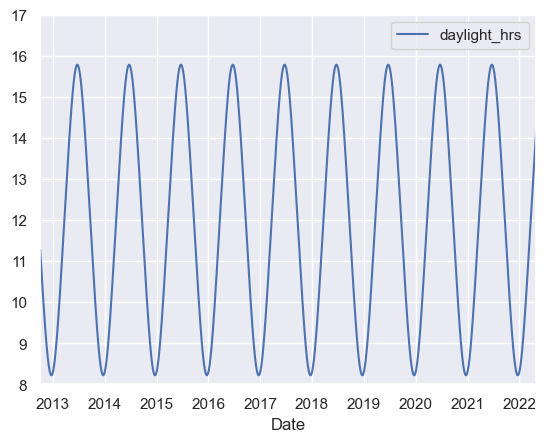

In [8]:
# Hint: Seattle es una ciudad donde el número de horas de luz en el día varían mucho durante el año
# Solución: Crearemos una variable que nos indique el número de horas de luz en el día
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [9]:
# Hint: El clima es importante cuando queremos salir a montar bicicleta
# Solución: Calculamos un promedio de temperatura por día 
# Agregamos una variable de probabilidad de lluvia
# Agregamos una variable para los días sin lluvia (es importante saber si habrá poca lluvia pero más importante saber si no habrá)

# Las temperaturas estan en 1/10 grados C; Convertimos los datos a grados C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
# La precipitación esta en 1/10 mm; Convertimos a pulgadas
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [10]:
# Hint: El calentamiento global modifica las temperaturas cada año
# Sol: Creamos una variable "contador" que nos ayuda a dar al modelo intuición sobre el año en curso
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [11]:
# Veamos el resultado
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,5.60,1.0,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,5.65,1.0,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,5.95,1.0,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,6.05,1.0,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,6.05,1.0,0.010959


##**RETO PRINCIPAL: Creación del modelo**

Ahora si viene el reto:

Agrega una columna en el dataframe ***daily*** que se llame ***predicted*** y coloca en dicha columna los valores de una predicción de trafico de bicicletas.

**Hint 1:** Las variables las creamos nosotros mismos y las conocemos a detalle. Podemos concluir que el único problema adicional es que tenemos algunos vacíos así que será el único tratamiento adicional que necesitamos y como tenemos datos suficientes los vamos a borrar. Para este reto tampoco haremos reducción de la dimensionalidad ni detección de outliers ya que sabemos (por construcción) que todas las variables son independientes y aportan de manera significativa. Además se encuentran en una escala correcta y sin outliers.

**Hint 2:** Crea un modelo de regresión lineal

**Hint 3:** sklearn tiene una clase para crear el modelo

```
from sklearn.linear_model import LinearRegression
```

La solución de esta sección se encuentra en el siguiente [link](https://mega.nz/#P!AgGqDTGUhsmpTVVIhlYIl4pqzc4LeOKqUUcMAjp_MO2yp1VC09Edyr6jW9e4Ji2mvLzqNpEYUOFBbpaCcnQjVzvURxx3AQx2rT8zrw0ISkDVal3Rnmm8zdCB5OUe3ODKQlWi3L4FWVQ)

el password lo compartiremos en la sesión de mentoría



In [12]:
daily.shape

(3497, 14)

In [13]:
daily.isna().sum()

Total              0
Mon                0
Tue                0
Wed                0
Thu                0
Fri                0
Sat                0
Sun                0
holiday            0
daylight_hrs       0
PRCP            1946
Temp (C)        1946
dry day         1946
annual             0
dtype: int64

In [14]:
# Importamos las bibliotecas
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [15]:
# Eliminamos las filas con valores nulos
daily.dropna(inplace = True) 

In [16]:
daily.shape

(1551, 14)

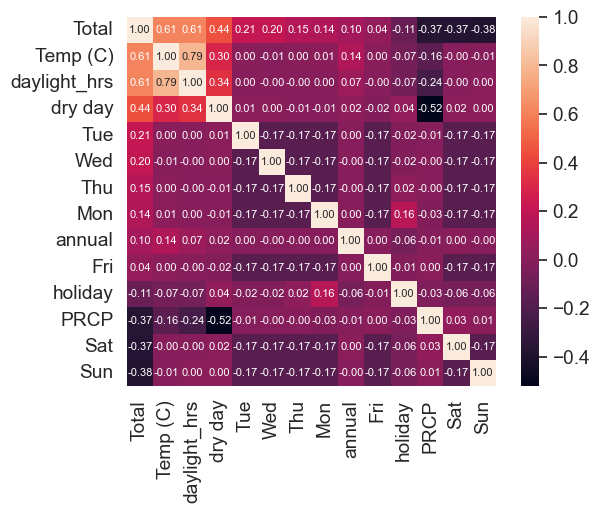

In [17]:
#Creamos el heatmap para la matriz de correlacion
corrmat = daily.corr()
k = 14
cols = corrmat.nlargest(k,'Total')['Total'].index
cols
cm = np.corrcoef(daily[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size' : 8}, yticklabels = cols.values, xticklabels = cols.values)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


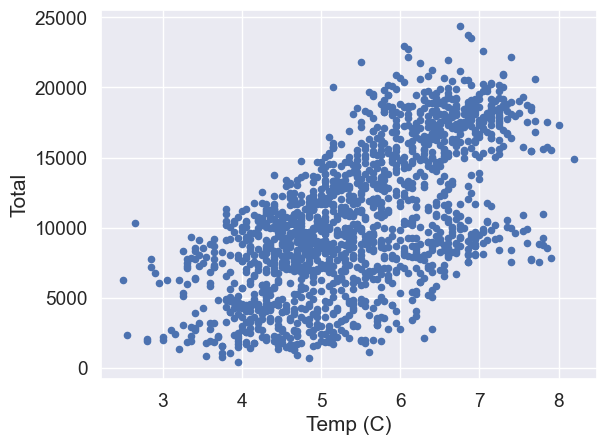

In [18]:
daily.plot.scatter(x='Temp (C)',y='Total')
## plt.xlim(-2,8) ## por si se necesita para hacer zoom
## plt.ylim(0,4100)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


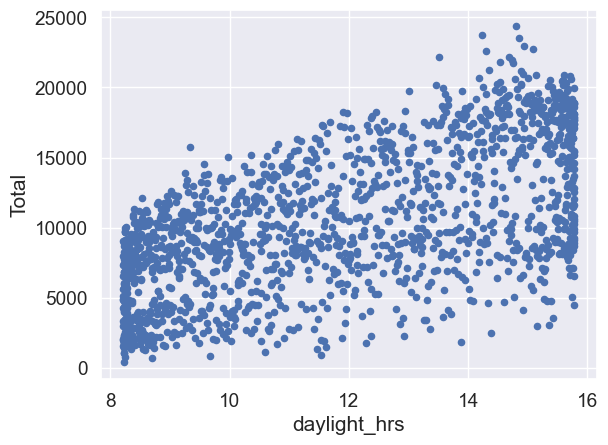

In [19]:
daily.plot.scatter(x='daylight_hrs',y='Total')
## plt.xlim(-2,8) ## por si se necesita para hacer zoom
## plt.ylim(0,4100)
plt.show()

In [20]:
daily.columns

Index(['Total', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'PRCP', 'Temp (C)', 'dry day', 'annual'],
      dtype='object')

In [21]:
# Seleccionamos las variables X a utilizar despues de analizar la correlacion
# Columnas: 'Temp (C)'
x = np.array(daily[['Temp (C)']])

In [32]:
# Seleccionamos la variable Y a predecir
# Columna: 'Total'
y = np.array(daily['Total'])

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state = 11)

In [24]:
x_train.shape

(1163, 1)

In [25]:
x_test.shape

(388, 1)

In [26]:
# Creamos un modelo de regresión lineal. 
# Las variables de día de la semana funcionan como intercepto, por eso decidimos configurar la regresión para que no incluya un intercepto
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
reglin = LinearRegression()

In [31]:
# Entrenamos el modelo
reglin.fit(x_train, y_train)
print(f' intercept: {reglin.intercept_}\n slope: {reglin.coef_}\n R^2: {reglin.score(x_train,y_train)}')

 intercept: -5659.111908660021
 slope: [2955.73472086]
 R^2: 0.3687711931030889


In [28]:
# Calculamos la predicción
prediccion = reglin.predict(x_test)
esperado = y_test
for p,e in zip(prediccion[::10],esperado[::10]):
    print(f'Prediccion: {p:.2f}, Esperado: {e:.2f}')

Prediccion: 6016.04, Esperado: 8032.00
Prediccion: 11188.58, Esperado: 14628.00
Prediccion: 6754.97, Esperado: 10764.00
Prediccion: 17543.41, Esperado: 8532.00
Prediccion: 6754.97, Esperado: 7392.00
Prediccion: 13109.80, Esperado: 19760.00
Prediccion: 12518.66, Esperado: 10404.00
Prediccion: 6459.40, Esperado: 9176.00
Prediccion: 6754.97, Esperado: 10564.00
Prediccion: 8380.63, Esperado: 8568.00
Prediccion: 7789.48, Esperado: 7280.00
Prediccion: 11188.58, Esperado: 10220.00
Prediccion: 8823.99, Esperado: 8348.00
Prediccion: 8528.41, Esperado: 3436.00
Prediccion: 15326.60, Esperado: 9152.00
Prediccion: 7937.27, Esperado: 8856.00
Prediccion: 16065.54, Esperado: 17764.00
Prediccion: 6311.61, Esperado: 2576.00
Prediccion: 16065.54, Esperado: 18836.00
Prediccion: 7937.27, Esperado: 3388.00
Prediccion: 16804.47, Esperado: 18760.00
Prediccion: 14587.67, Esperado: 12012.00
Prediccion: 6459.40, Esperado: 2512.00
Prediccion: 18577.91, Esperado: 14896.00
Prediccion: 10006.28, Esperado: 3500.00
Pr

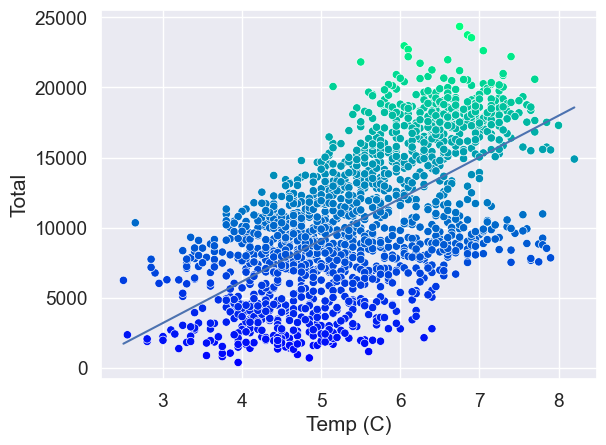

In [29]:
axes = sns.scatterplot(data = daily, x = 'Temp (C)', y = 'Total', hue = 'Total', palette = 'winter', legend = False)
x = np.array([min(daily['Temp (C)'].values), max(daily['Temp (C)'].values)])
predice = (lambda x: reglin.coef_ * x + reglin.intercept_)
y = predice(x)
line = plt.plot(x,y)

Visualización del modelo de predicción de tráfico vs trafico real

## Ahora vamos a realizar una regresion lineal pero sin el split y comparar

In [55]:
x2 = np.array(daily[['Temp (C)']])
y2 = np.array(daily['Total'])
reglin2 = LinearRegression()
reglin2.fit(x2, y2)
print(f' intercept: {reglin2.intercept_}\n slope: {reglin2.coef_}\n R^2: {reglin2.score(x2,y2)}')

 intercept: -5485.452587982796
 slope: [2928.72443297]
 R^2: 0.3760645361324565


In [34]:
print(f' Total = {reglin2.intercept_} + {reglin2.coef_} Temp (C)')

 Total = -5485.452587982796 + [2928.72443297] Temp (C)


In [59]:
daily['Predicted'] = reglin2.predict(x2)
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,Predicted
Date,,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,5.60,1.0,0.000000,10915.404237
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,5.65,1.0,0.002740,11061.840458
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,5.95,1.0,0.005479,11940.457788
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,6.05,1.0,0.008219,12233.330231
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,6.05,1.0,0.010959,12233.330231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,4420.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.243449,0.000197,4.20,0.0,4.235616,6815.190030
2016-12-28,5888.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.252283,0.000000,4.25,1.0,4.238356,6961.626252
2016-12-29,4536.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.262456,0.000197,4.40,0.0,4.241096,7400.934917


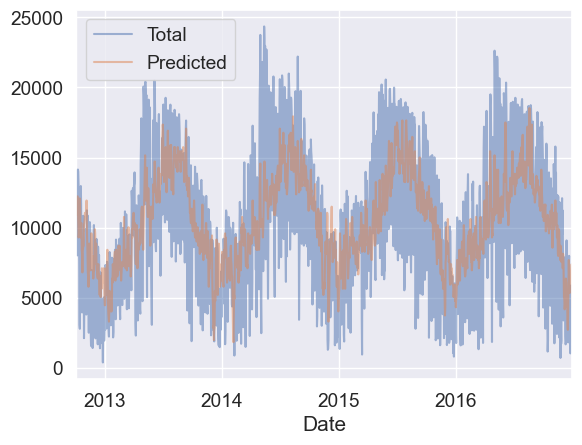

In [45]:
daily[['Total', 'Predicted']].plot(alpha=0.5);

## Ahora lo hare con todas las variables en X

In [57]:
x3 = np.array(daily[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs', 'PRCP', 'Temp (C)', 'dry day', 'annual']])
y3 = np.array(daily['Total'])
reglin3 = LinearRegression()
reglin3.fit(x3, y3)
print(f' intercept: {reglin3.intercept_}\n slope: {reglin3.coef_}\n R^2: {reglin3.score(x3,y3)}')

 intercept: -4469.063744542331
 slope: [ 1.96582060e+03  2.56607499e+03  2.52264646e+03  1.92005143e+03
  5.68961541e+02 -4.66657294e+03 -4.87698208e+03 -4.58067887e+03
  4.64390628e+02 -6.77201876e+05  1.56299537e+03  2.05668909e+03
  9.52976867e+01]
 R^2: 0.862806496015798


In [60]:
daily['Predicted2'] = reglin3.predict(x3)
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,Predicted,Predicted2
Date,,,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,5.60,1.0,0.000000,10915.404237,14100.145825
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,5.65,1.0,0.002740,11061.840458,13548.925921
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,5.95,1.0,0.005479,11940.457788,12640.012742
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,6.05,1.0,0.008219,12233.330231,7534.113041
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,6.05,1.0,0.010959,12233.330231,7297.100792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,4420.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.243449,0.000197,4.20,0.0,4.235616,6815.190030,8760.109183
2016-12-28,5888.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.252283,0.000000,4.25,1.0,4.238356,6961.626252,10989.190706
2016-12-29,4536.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8.262456,0.000197,4.40,0.0,4.241096,7400.934917,8436.033493


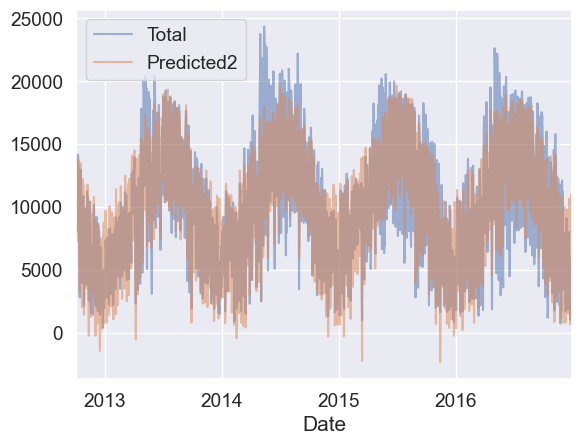

In [61]:
daily[['Total', 'Predicted2']].plot(alpha=0.5);

##**Reto adicional**

En la gráfica podemos notar que el modelo funciona bastante bien. Sin embargo tenemos una oportunidad de mejora para las predicciones de verano.

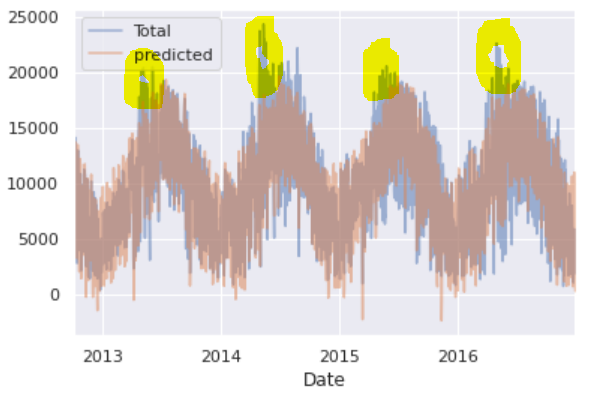

**Aprendizaje:** La creación de un modelo es un proceso experimental. Donde siempre revisamos los resultados y volvemos a preguntarnos si necesitamos mas/menos variables, mas/menos datos, mayor calidad de los datos, revisar los supuestos del modelo, etc.

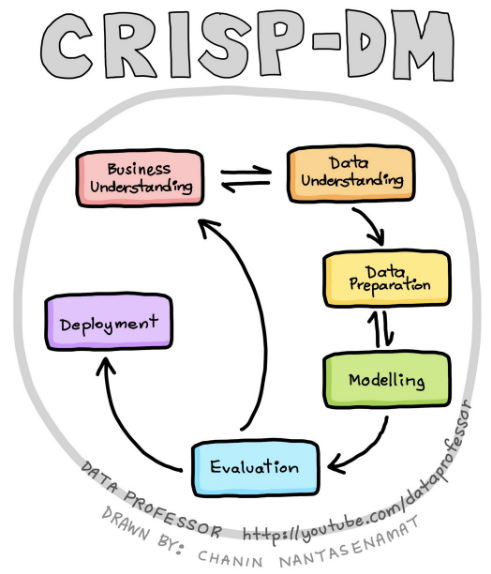

Por lo anterior el reto adicional consiste en crear nuevas variables que ayuden a mejorar la predicción anterior.

**Hint:** El modelo de regresión lineal encuentra relaciones lineales entre las variables y el target. Sin embargo es posible que haya relaciones no lineales que deban ser tomadas en consideración por ejemplo:

Primero vemos que hay una tendencia relativamente estable en la línea de base semanal: hay muchos más ciclistas entre semana que los fines de semana y días festivos. Vemos que por cada hora adicional de luz diurna, 129 ± 9 personas más eligen viajar; un aumento de temperatura de un grado centígrado anima a 65 ± 4 personas a agarrar su bicicleta; un día seco significa un promedio de 548 ± 33 ciclistas más, y cada pulgada de precipitación significa que 665 ± 62 personas más dejan su bicicleta en casa. Una vez que se toman en cuenta todos estos efectos, vemos un modesto aumento de 27 ± 18 nuevos pasajeros diarios cada año.

Es casi seguro que a nuestro modelo le falta alguna información relevante. Por ejemplo, los efectos no lineales (como los efectos de la precipitación y la temperatura fría) y las tendencias no lineales dentro de cada variable (como la falta de inclinación a montar en bicicleta a temperaturas muy frías y muy altas) no se pueden tener en cuenta en este modelo. Además, hemos descartado parte de la información más detallada (como la diferencia entre una mañana lluviosa y una tarde lluviosa) y hemos ignorado las correlaciones entre días (como el posible efecto de un martes lluvioso en las cifras del miércoles, o el efecto de un día soleado inesperado después de una racha de días lluviosos). ¡Todos estos son efectos potencialmente interesantes, y ahora tiene las herramientas para comenzar a explorarlos si lo desea!